In [1]:
#!pip install category_encoders

In [213]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

import category_encoders as ce


In [214]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample = pd.read_csv('submit_sample.csv', header=None)

In [215]:
train.info(), train.shape, test.shape, sample.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27100 non-null  int64 
 1   job        27100 non-null  object
 2   marital    27100 non-null  object
 3   education  27100 non-null  object
 4   default    27100 non-null  object
 5   balance    27100 non-null  int64 
 6   housing    27100 non-null  object
 7   loan       27100 non-null  object
 8   contact    27100 non-null  object
 9   day        27100 non-null  int64 
 10  month      27100 non-null  object
 11  duration   27100 non-null  int64 
 12  campaign   27100 non-null  int64 
 13  pdays      27100 non-null  int64 
 14  previous   27100 non-null  int64 
 15  poutcome   27100 non-null  object
 16  y          27100 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 3.7+ MB


(None, (27100, 17), (18050, 16), (18050, 2))

In [216]:
test['y'] = -999

In [217]:
all_df = pd.concat([train, test], axis=0)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45150 non-null  int64 
 1   job        45150 non-null  object
 2   marital    45150 non-null  object
 3   education  45150 non-null  object
 4   default    45150 non-null  object
 5   balance    45150 non-null  int64 
 6   housing    45150 non-null  object
 7   loan       45150 non-null  object
 8   contact    45150 non-null  object
 9   day        45150 non-null  int64 
 10  month      45150 non-null  object
 11  duration   45150 non-null  int64 
 12  campaign   45150 non-null  int64 
 13  pdays      45150 non-null  int64 
 14  previous   45150 non-null  int64 
 15  poutcome   45150 non-null  object
 16  y          45150 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 6.2+ MB


In [218]:
all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,-999
18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,-999
18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,-999


In [219]:
categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col]=lbl.transform(all_df[col])


In [220]:
all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,1,0
1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,3,1
2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,0,0
3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,0,0
4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,6,1,2,0,98357,1,0,0,6,4,101,2,417,0,0,-999
18046,34,1,1,1,0,29621,1,0,0,12,7,345,1,815,0,3,-999
18047,34,0,2,1,0,94260,1,0,2,16,7,121,2,370,0,3,-999


In [221]:
all_df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [222]:
# One Hot Encoding
ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
ce_ohe.fit(all_df.drop('y', axis=1))


OneHotEncoder(cols=[], handle_unknown='impute')

In [223]:
X = ce_ohe.transform(all_df[all_df['y'] != -999].drop('y', axis=1))
y = all_df[all_df['y'] != -999]['y']

In [224]:
X.shape, y.shape

((27100, 16), (27100,))

In [225]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

## XGBoost

In [228]:
# XGBoost が扱うデータセットの形式に直す
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_eval = xgb.DMatrix(X_valid, label=y_valid)

# 学習用のパラメータ
xgb_params = {
    'objective': 'binary:logistic', # 二値分類問題
    'max_depth': 5,
    'eta': 0.1,
    'eval_metric': 'auc',
    'random_state': 0,
    'early_stopping_rounds': 10,
}

# モデルを学習する
xgb_model = xgb.train(
    xgb_params, xgb_train,
    evals=[(xgb_train, 'train'), (xgb_eval, 'eval')],
    num_boost_round=1000,  # 学習ラウンド数は適当
    verbose_eval=100,
)

[08:17:17] WARNING: /workspace/src/learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.77790	eval-auc:0.76754
[100]	train-auc:0.91158	eval-auc:0.84289
[200]	train-auc:0.94604	eval-auc:0.84428
[300]	train-auc:0.96758	eval-auc:0.84449
[400]	train-auc:0.98146	eval-auc:0.84085
[500]	train-auc:0.98864	eval-auc:0.83747
[600]	train-auc:0.99291	eval-auc:0.83373
[700]	train-auc:0.99577	eval-auc:0.83152
[800]	train-auc:0.99748	eval-auc:0.82858
[900]	train-auc:0.99858	eval-auc:0.82674
[999]	train-auc:0.99920	eval-auc:0.82426


In [229]:
all_pred = pd.DataFrame()

In [230]:
xgb_y_pred = xgb_model.predict(xgb.DMatrix(X, label=y))
print(xgb_y_pred)

all_pred['xgb'] = xgb_y_pred


[3.8485686e-04 7.3056072e-01 1.3330099e-04 ... 1.7412081e-01 1.8531658e-02
 5.9789809e-04]


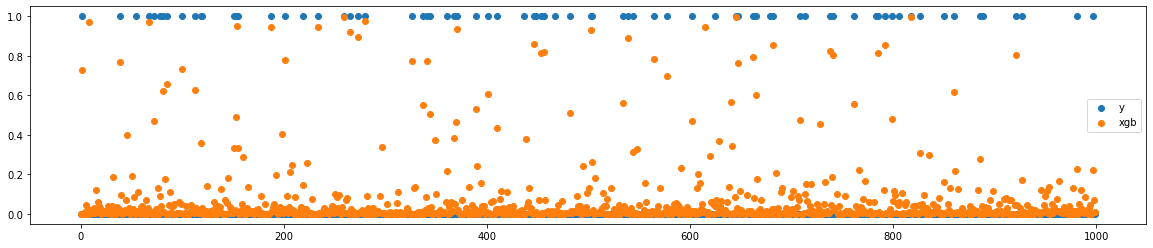

In [231]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='xgb')
plt.legend()

### for sklearn

In [232]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic', max_depth=5, learning_rate=0.1, n_estimators=1000, eval_metric='auc', random_state=0, early_stopping_rounds=10)
xgb.fit(X_train, y_train)


[08:17:24] WARNING: /workspace/src/learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [233]:
xgb_y_pred = xgb.predict(X)
print(xgb_y_pred)

all_pred['xgb_sk'] = xgb_y_pred


[0 1 0 ... 0 0 0]


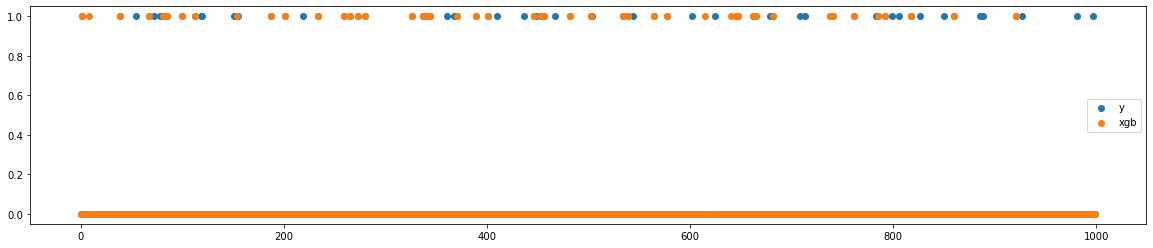

In [234]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='xgb')
plt.legend()

## LightGBM

In [235]:
# 使用モデルはLGB（パラメータチューニング無）
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

lgb_params = {
    'objective': 'binary', 
    'max_depth': 3,
    'eta': 0.1,
    'metric': 'auc',
    'random_state': 0,
}

lgb_model = lgb.train(
    lgb_params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=100,
    num_boost_round=1000
)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's auc: 0.875722	valid_1's auc: 0.849082
[200]	training's auc: 0.89565	valid_1's auc: 0.852441
[300]	training's auc: 0.910652	valid_1's auc: 0.852049
[400]	training's auc: 0.921516	valid_1's auc: 0.85092
[500]	training's auc: 0.930179	valid_1's auc: 0.849656
[600]	training's auc: 0.937423	valid_1's auc: 0.846944
[700]	training's auc: 0.943274	valid_1's auc: 0.844314
[800]	training's auc: 0.948878	valid_1's auc: 0.842758
[900]	training's auc: 0.953077	valid_1's auc: 0.840585
[1000]	training's auc: 0.957552	valid_1's auc: 0.838639


In [236]:
lgb_y_pred = lgb_model.predict(X, num_iteration=lgb_model.best_iteration)
print(lgb_y_pred)

all_pred['lgb'] = lgb_y_pred


[0.00482016 0.4714975  0.00113461 ... 0.1620422  0.0586502  0.00204245]


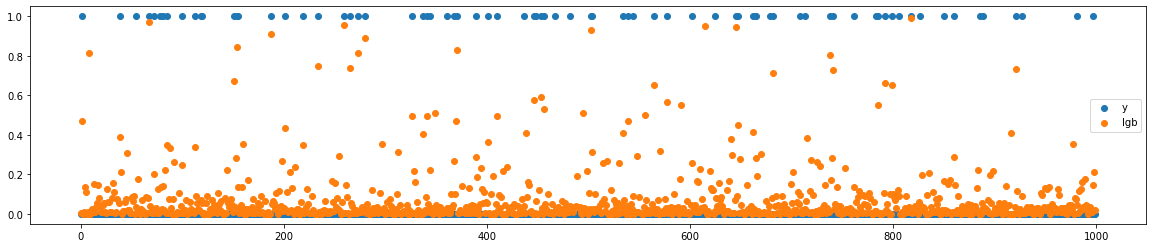

In [237]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], lgb_y_pred[:1000], alpha=1, label='lgb')
plt.legend()

### for sklearn

In [238]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective='binary', max_depth=3, learning_rate=0.1,eval_metric='auc', n_estimators=1000)
lgb.fit(X_train, y_train)

LGBMClassifier(eval_metric='auc', max_depth=3, n_estimators=1000,
               objective='binary')

In [239]:
lgb_y_pred = lgb.predict(X)
print(lgb_y_pred)

all_pred['lgb_sk'] = lgb_y_pred


[0 0 0 ... 0 0 0]


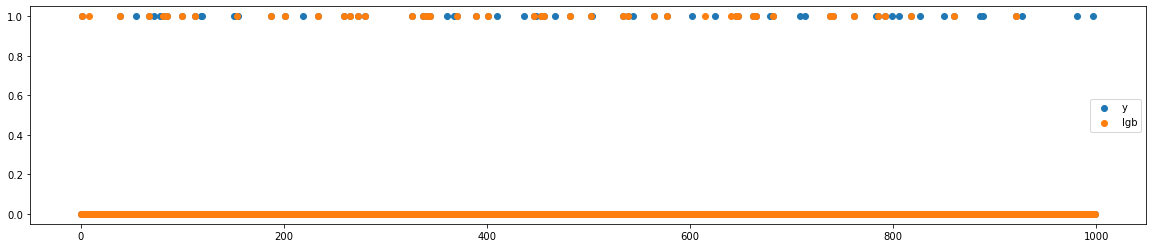

In [240]:
plt.figure(figsize=(20, 4))
plt.scatter(y.index[:1000], y[:1000], alpha=1, label='y')
plt.scatter(y.index[:1000], xgb_y_pred[:1000], alpha=1, label='lgb')
plt.legend()

In [241]:
all_pred

,xgb,xgb_sk,lgb,lgb_sk
0,0.000385,0,0.004820,0
1,0.730561,1,0.471498,0
2,0.000133,0,0.001135,0
3,0.000587,0,0.011405,0
4,0.007759,0,0.134130,0
...,...,...,...,...
27095,0.000266,0,0.002024,0
27096,0.012566,0,0.018053,0
27097,0.174121,0,0.162042,0
27098,0.018532,0,0.058650,0


In [21]:
sample[1] = pred
sample.to_csv('submit_20200809_03.csv', index=None, header=None)

NameError: name 'pred' is not defined